In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Compute Fst values with *PLINK*

In [2]:
import re
import pandas as pd

from os.path import expanduser, join, isfile
from components.dataset import Dataset
from components.panel import Panel
from subprocess import call


PANELS_DIR = expanduser("~/tesina/1000Genomes/all_panels")  # Reads from here
DATASETS_DIR = expanduser("~/tesina/dataset_dumps")  # Reads from here
WORKDIR = expanduser("~/tesina/1000Genomes/fst_analysis")  # Writes output here

analysis_files = []
for dataset in Dataset.all_datasets():

    dataset.write_clusters_files(DATASETS_DIR)  # .clusters files!
    dataset.write_samples_file(DATASETS_DIR)  # .samples files!

    for panel in Panel.all_panels_and_subpanels() + Panel.all_control_panels():
        
        if not isfile(join(PANELS_DIR, panel.label + ".bed")):
            raise OSError("WARNING: No '{}' bfiles found".format(panel.label))

        # Generate dataset/panel specific bedfiles
        new_bfile = join(WORKDIR, "{}.{}".format(dataset.label, panel.label))
        command = ["plink",
                   "--bfile", join(PANELS_DIR, panel.label),
                   "--keep-fam", join(DATASETS_DIR, "{}.samples".format(dataset.label)),
                   "--make-bed", "--out", new_bfile]       
        call(command)
        
        # Compute Fst for each dataset/panel/population level combination
        for population_level in ["population", "superpopulation"]:
            
            clusters_file = join(DATASETS_DIR, "{}.{}.clusters".format(dataset.label, population_level))
            level_analysis_file = "{}.{}".format(new_bfile, population_level)
            command = ["plink",
                       "--bfile", new_bfile,
                       "--within", clusters_file, "--fst",
                       "--make-bed", "--out", level_analysis_file]

            call(command)
            analysis_files.append(level_analysis_file + ".fst")

# Read the Fst files

In [3]:
def fst_format(x):
    # return x
    return round(x, 4)

frames = []

for filepath in analysis_files:
    dataset_label, panel_label, pop_level = \
        re.search("(\w*)\.(\w*).(\w*).", filepath).groups()

    try:
        fst_df = pd.read_table(filepath)
    except OSError:
        print("[!] No file {}".format(filepath))

    fst_df["panel"] = panel_label
    fst_df["dataset"] = dataset_label
    fst_df["pop_level"] = pop_level
    mean_fst = fst_df["FST"].mean()
    
    # print(dataset_label, panel_label, population_level, mean_fst)
    frames.append(fst_df)
    
fst_df = pd.concat(frames).set_index(["pop_level", "dataset", "panel", "SNP"])

mean_fst = fst_df.groupby(level=["dataset", "panel", "pop_level"]).mean()["FST"]
mean_fst = mean_fst.map(fst_format).to_frame().sort_index()
mean_fst = mean_fst.reset_index().pivot_table(index=["pop_level", "dataset"],
                                              columns="panel", values="FST")
mean_fst

[!] No file /home/juan/tesina/1000Genomes/fst_analysis/L.100_SNPs_from_GAL_Affy.superpopulation.fst
[!] No file /home/juan/tesina/1000Genomes/fst_analysis/L.10_SNPs_from_GAL_Affy.superpopulation.fst
[!] No file /home/juan/tesina/1000Genomes/fst_analysis/L.15_SNPs_from_GAL_Affy.superpopulation.fst
[!] No file /home/juan/tesina/1000Genomes/fst_analysis/L.20_SNPs_from_GAL_Affy.superpopulation.fst
[!] No file /home/juan/tesina/1000Genomes/fst_analysis/L.25_SNPs_from_GAL_Affy.superpopulation.fst
[!] No file /home/juan/tesina/1000Genomes/fst_analysis/L.50_SNPs_from_GAL_Affy.superpopulation.fst
[!] No file /home/juan/tesina/1000Genomes/fst_analysis/L.5_SNPs_from_GAL_Affy.superpopulation.fst
[!] No file /home/juan/tesina/1000Genomes/fst_analysis/L.GAL_Affy.superpopulation.fst
[!] No file /home/juan/tesina/1000Genomes/fst_analysis/L.GAL_Completo.superpopulation.fst
[!] No file /home/juan/tesina/1000Genomes/fst_analysis/L.GAL_Faltantes.superpopulation.fst
[!] No file /home/juan/tesina/1000Genome

panel                    100_SNPs_from_GAL_Affy  10_SNPs_from_GAL_Affy  \
pop_level       dataset                                                  
population      LE                       0.0976                 0.0974   
                LEA                      0.4262                 0.5150   
                LEAC                     0.3953                 0.4682   
                LEACI                    0.3739                 0.4456   
superpopulation L                        0.0925                 0.0801   
                LE                       0.0664                 0.0750   
                LEA                      0.4520                 0.5458   
                LEAC                     0.4108                 0.4887   
                LEACI                    0.3821                 0.4584   

panel                    15_SNPs_from_GAL_Affy  20_SNPs_from_GAL_Affy  \
pop_level       dataset                                                 
population      LE                      0.0895                 0.1097   
                LEA                     0.5111                 0.4830   
                LEAC                    0.4574                 0.4469   
                LEACI                   0.4324                 0.4250   
superpopulation L                       0.0762                 0.0933   
                LE                      0.0669                 0.0821   
                LEA                     0.5466                 0.5079   
                LEAC                    0.4799                 0.4639   
                LEACI                   0.4470                 0.4345   

panel                    25_SNPs_from_GAL_Affy  50_SNPs_from_GAL_Affy  \
pop_level       dataset                                                 
population      LE                      0.1030                 0.0785   
                LEA                     0.4885                 0.4916   
                LEAC                    0.4518                 0.4569   
                LEACI                   0.4278                 0.4320   
superpopulation L                       0.0889                 0.0716   
                LE                      0.0758                 0.0537   
                LEA                     0.5189                 0.5328   
                LEAC                    0.4718                 0.4836   
                LEACI                   0.4400                 0.4503   

panel                    5_SNPs_from_GAL_Affy    CPx1   CPx10  CPx100  \
pop_level       dataset                                                 
population      LE                     0.0731  0.0219  0.0226  0.0224   
                LEA                    0.5909  0.0623  0.0603  0.0598   
                LEAC                   0.5257  0.0741  0.0707  0.0697   
                LEACI                  0.5092  0.0716  0.0687  0.0676   
superpopulation L                      0.0652  0.0183  0.0188  0.0189   
                LE                     0.0512  0.0180  0.0189  0.0184   
                LEA                    0.6328  0.0689  0.0665  0.0658   
                LEAC                   0.5510  0.0797  0.0755  0.0744   
                LEACI                  0.5270  0.0748  0.0713  0.0701   

panel                    GAL_Affy  GAL_Completo  GAL_Faltantes  
pop_level       dataset                                         
population      LE         0.1268        0.1365         0.1440  
                LEA        0.3646        0.3330         0.3104  
                LEAC       0.3370        0.3092         0.2894  
                LEACI      0.3183        0.2905         0.2706  
superpopulation L          0.0991        0.1044         0.1087  
                LE         0.1102        0.1214         0.1299  
                LEA        0.3863        0.3488         0.3216  
                LEAC       0.3474        0.3153         0.2922  
                LEACI      0.3221        0.2905         0.2676

# Plot a heatmap of the mean Fst per dataset/panel/pop_level

In [5]:
df.T

dataset,L,LE,LEA,LEAC,LEACI
CPx1 · 438 SNPs,0.0183,0.0180,0.0689,0.0797,0.0748
"CPx10 · 4,424 SNPs",0.0188,0.0189,0.0665,0.0755,0.0713
"CPx100 · 43,144 SNPs",0.0189,0.0184,0.0658,0.0744,0.0701
GAL_Completo · 445 AIMs,0.1044,0.1214,0.3488,0.3153,0.2905
GAL_Affy · 179 AIMs,0.0991,0.1102,0.3863,0.3474,0.3221
100 AIMs from GAL Affy,0.0925,0.0664,0.4520,0.4108,0.3821
50 AIMs from GAL Affy,0.0716,0.0537,0.5328,0.4836,0.4503
25 AIMs from GAL Affy,0.0889,0.0758,0.5189,0.4718,0.4400
10 AIMs from GAL Affy,0.0801,0.0750,0.5458,0.4887,0.4584
5 AIMs from GAL Affy,0.0652,0.0512,0.6328,0.5510,0.5270


Fst promedio por población
/home/juan/tesina/charts/panel_analyses/fst_barchart__per_population


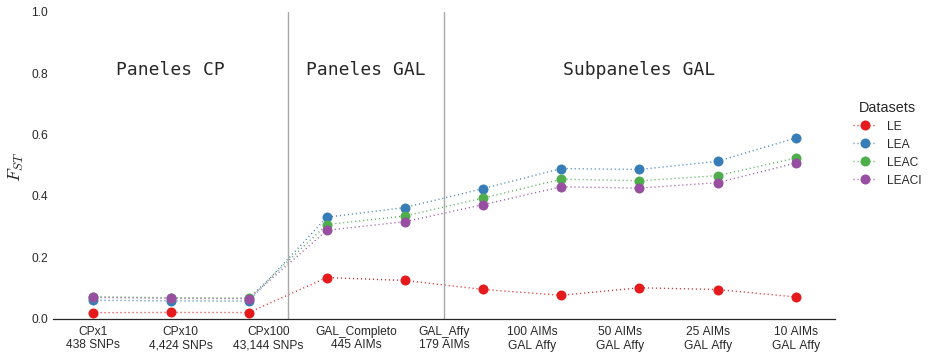

Fst promedio por continente
/home/juan/tesina/charts/panel_analyses/fst_barchart__per_superpopulation


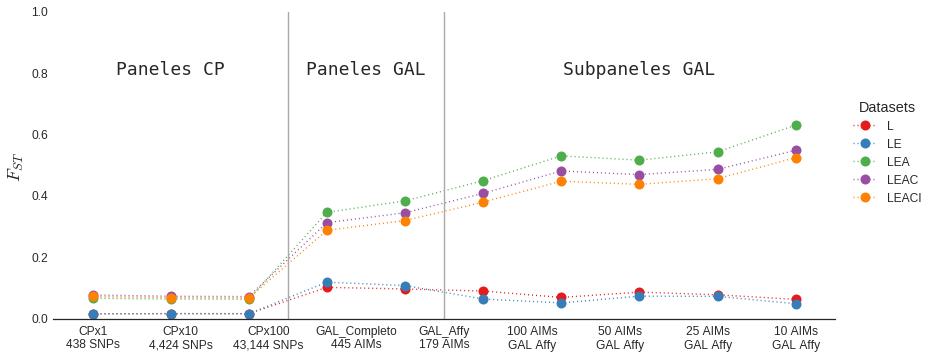

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from os.path import expanduser, join


fdir = expanduser("~/tesina/charts/panel_analyses")

sns.set_context("paper", font_scale=1.5)
sns.set_style("ticks")
sns.set_style("white")

trans = {"population": "población", "superpopulation": "continente"}
keep_these_panels = ["CPx1", "CPx10", "CPx100", "GAL_Completo", "GAL_Affy",
                     "100_SNPs_from_GAL_Affy", "50_SNPs_from_GAL_Affy",
                     "25_SNPs_from_GAL_Affy", "10_SNPs_from_GAL_Affy",
                     "5_SNPs_from_GAL_Affy"]

for level in mean_fst.index.get_level_values("pop_level").unique():
    df = mean_fst.loc[level]
    df = df[keep_these_panels]
    df.columns = [Panel(panel_label).name for panel_label in df.columns]
    xticklabels = [col.replace(" from ", "\n").replace(" · ", "\n")
                   for col in df.columns]

    # === Barplot    
    color = sns.color_palette("Set1", 10)
    ax = df.T.plot(figsize=(14, 5.5), rot=0, color=color, linestyle="dotted",
                   marker="o", markersize=10) #, width=0.8) # kind="bar", 
    ax.set_ylabel("$F_{ST}$", fontsize=18, fontweight="bold")
    ax.legend(fancybox=True, loc="best", bbox_to_anchor=(1.01, .75),
              title="Datasets")
    
    # Annotate groups of panels
    ax.axvline(2.5, color="darkgray")
    ax.axvline(4.5, color="darkgray")
    text_yloc = 0.8
    texts = [(1, text_yloc, "Paneles CP"),
             (3.5, text_yloc, "Paneles GAL"),
             (7, text_yloc, "Subpaneles GAL")]
    for params in texts:
        ax.text(*params, fontsize=18, horizontalalignment="center",
                family="monospace", fontname="Courier")

    ax.set_ylim([0, 1])
    ygrid_points = np.linspace(0, 1, 6)
    ax.set_yticks(ygrid_points)
    
    ax.set_xlim([-0.5, 9.5])
    ax.set_xticks(np.linspace(0, 9, 9))

    ax.set_xticklabels(xticklabels, rotation=0)
    sns.despine(left=True)
    ax.xaxis.grid(False)
    caption = "Fst promedio por {}".format(trans[level])
    filepath = join(fdir, "fst_barchart__per_{}".format(level))
    plt.savefig(filepath, bbox_inches="tight")
    print(caption)
    print(filepath)
    plt.show()

    # === Heatmap # saved code in the nex cell   


In [ ]:
# # == Heatmap code for the previous cell

#     fig = plt.figure()
#     ax = sns.heatmap(df, annot=True, linewidths=.5, fmt=".1%", robust=True,
#                      vmax=1, vmin=0, cmap="YlOrRd", cbar=False)
    
#     fig = ax.get_figure()
#     fig.set_size_inches(15, 6)
#     ax.set_ylabel("Datasets", labelpad=15)
#     ax.set_xlabel("")
#     ax.set_xticklabels(xticklabels, rotation=0)
#     for vline in [3, 5]:
#         ax.axvline(vline, color="black", linewidth=2)        
    
#     text_yloc = 4.15
#     texts = [
#         (1.5, text_yloc, "Paneles CP"),
#         (4, text_yloc, "Paneles GAL"),
#         (7.5, text_yloc, "Subpaneles GAL")
#     ]
#     for params in texts:
#         ax.text(*params, fontsize=16, horizontalalignment="center")
        
#     ax.axhline(3, color="black", linewidth=2, linestyle="--")        
#     ax.text(10.1, 3.5, "Sin africanos", rotation=270,
#             verticalalignment="center")
#     ax.text(10.1, 1.5, "Incluyendo africanos", rotation=270,
#             verticalalignment="center")
    
#     caption = "Fst promedio por {}".format(trans[level])
#     filepath = join(fdir, "fst_heatmap__per_{}".format(level))
#     plt.savefig(filepath, bbox_inches="tight")
#     print(caption)
#     print(filepath)
#     plt.show()

# Safety check between my means and Plink ones in the .log files

In [5]:
%%bash

grep Mean ~/tesina/1000Genomes/fst_analysis/*.log | \
ruby -F: -lane 'puts [$F[0].gsub("/home/juan/tesina/1000Genomes/fst_analysis/", "").gsub(".", "\t"), $F.last].join("\t")' \
> ~/tesina/1000Genomes/fst_analysis/plink_fst_means

In [6]:
columns = ["dataset", "panel", "pop_level", "dropme", "FST"]
plink_fst_means = pd.read_table(join(WORKDIR, "plink_fst_means"), header=None, names=columns)
plink_fst_means.drop("dropme", inplace=True, axis=1)
plink_fst_means["FST"] = plink_fst_means["FST"].astype(float).map(lambda x: round(x, 2))
plink_fst_means = plink_fst_means.pivot_table(index=["pop_level", "dataset"],
                                              columns="panel", values="FST")
plink_fst_means - mean_fst

NameError: name 'means' is not defined